# Ковариация и корреляция

In [1]:
import requests                  # [handles the http interactions](http://docs.python-requests.org/en/master/) 
from bs4 import BeautifulSoup    # beautiful soup handles the html to text conversion and more
import re                        # regular expressions are necessary for finding the crumb (more on crumbs later)
from datetime import datetime    # string to datetime object conversion
from time import mktime          # mktime transforms datetime objects to unix timestamps
import pandas as pd 
import matplotlib.pyplot as plt
from string import ascii_letters
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
# by https://maikros.github.io/yahoo-finance-python/

def _get_crumbs_and_cookies(stock):
    """
    get crumb and cookies for historical data csv download from yahoo finance
    
    parameters: stock - short-handle identifier of the company 
    
    returns a tuple of header, crumb and cookie
    """
    
    url = 'https://finance.yahoo.com/quote/{}/history'.format(stock)
    with requests.session():
        header = {'Connection': 'keep-alive',
                   'Expires': '-1',
                   'Upgrade-Insecure-Requests': '1',
                   'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; WOW64) \
                   AppleWebKit/537.36 (KHTML, like Gecko) Chrome/54.0.2840.99 Safari/537.36'
                   }
        
        website = requests.get(url, headers=header, verify=False) ### verify=False depends of HW
        soup = BeautifulSoup(website.text, 'lxml')
        crumb = re.findall('"CrumbStore":{"crumb":"(.+?)"}', str(soup))

        return (header, crumb[0], website.cookies)

In [3]:
def convert_to_unix(date):
    """
    converts date to unix timestamp
    
    parameters: date - in format (dd-mm-yyyy)
    
    returns integer unix timestamp
    """
    datum = datetime.strptime(date, '%d-%m-%Y')
    
    return int(mktime(datum.timetuple()))

In [4]:
def load_csv_data(stock, interval='1d', day_begin='01-03-2018', day_end='28-03-2018'):
    """
    queries yahoo finance api to receive historical data in csv file format
    
    parameters: 
        stock - short-handle identifier of the company
        
        interval - 1d, 1wk, 1mo - daily, weekly monthly data
        
        day_begin - starting date for the historical data (format: dd-mm-yyyy)
        
        day_end - final date of the data (format: dd-mm-yyyy)
    
    returns a list of comma seperated value lines
    """
    day_begin_unix = convert_to_unix(day_begin)
    day_end_unix = convert_to_unix(day_end)
    
    header, crumb, cookies = _get_crumbs_and_cookies(stock)
    
    with requests.session():
            url = 'https://query1.finance.yahoo.com/v7/finance/download/' \
                  '{stock}?period1={day_begin}&period2={day_end}&interval={interval}&events=history&crumb={crumb}' \
                  .format(stock=stock, day_begin=day_begin_unix, day_end=day_end_unix, interval=interval, crumb=crumb)

            website = requests.get(url, headers=header, cookies=cookies, verify=False) ### verify=False depends of HW

            parse = website.text.split('\n')[:-1]
    
    return np.array(list(map(lambda x: x.split(','), parse))), parse[0].split(',')
          
    

In [5]:
"""tickers = [ "AAPL", "AMD", "AMZN", "ATVI", "BA", "DIS", "FB", "GOOG",  "INTC", "MA",
            "MCD", "MSFT", "MU", "NFLX", "NVDA", "PFE", "T",  "TWTR", "V",   "XOM",
            "WMT", "GM", "DAL", "AVGO", "UNH", "CSCO", "CAT", "BIIB"]"""


tickers = ["GOOG","BA",  "INTC", "MU", "PFE"]
portfolio = pd.DataFrame()
for ticker in tickers:
    values, columns = load_csv_data(ticker,
                                    interval='1d', 
                                    day_begin='01-03-2018', 
                                    day_end='10-02-2022')
    portfolio[ticker] = pd.DataFrame(values[1:], columns = columns)['Adj Close']
portfolio.index = pd.DataFrame(values[1:], columns = columns)['Date']
portfolio = portfolio.astype('float')
portfolio.head()#.dtypes  

,GOOG,BA,INTC,MU,PFE
Date,,,,,
2018-02-28,1104.729980,346.887482,44.228321,48.623508,29.460474
2018-03-01,1069.520020,334.897095,42.927219,47.438053,28.908749
2018-03-02,1078.920044,330.089508,43.950153,48.922363,29.168383
2018-03-05,1090.930054,337.827667,44.641083,51.831203,29.306318
2018-03-06,1095.060059,334.159729,45.502487,53.534676,29.111593


In [6]:
portfolio.shape

(995, 5)

In [7]:
portfolio.dtypes

GOOG    float64
BA      float64
INTC    float64
MU      float64
PFE     float64
dtype: object

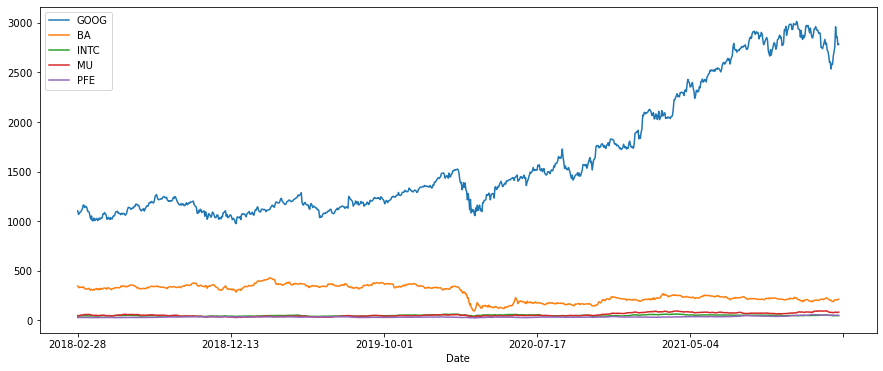

In [8]:
portfolio.plot(figsize=(15,6))
plt.show()

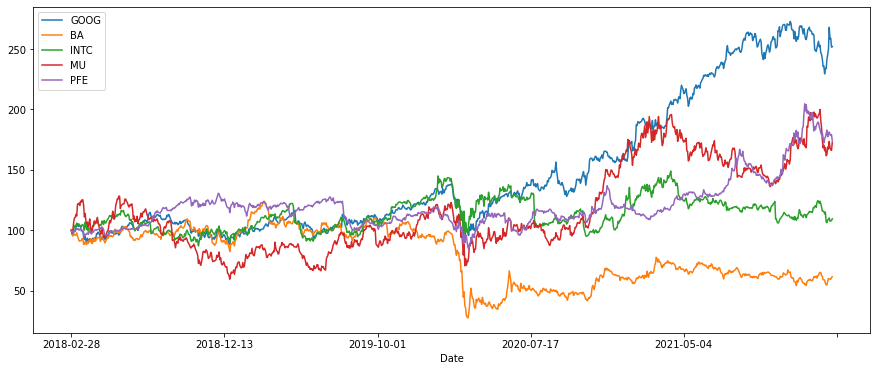

In [9]:
(portfolio / portfolio.iloc[0] * 100).plot(figsize = (15, 6));
plt.show()

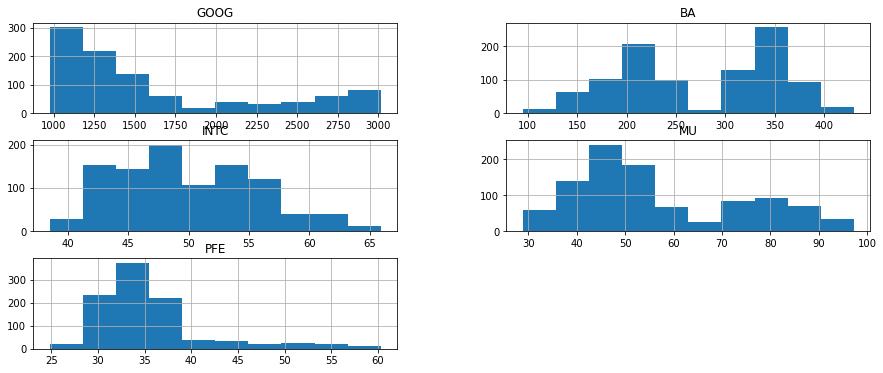

In [10]:
portfolio.hist(figsize=(15,6))
plt.show()

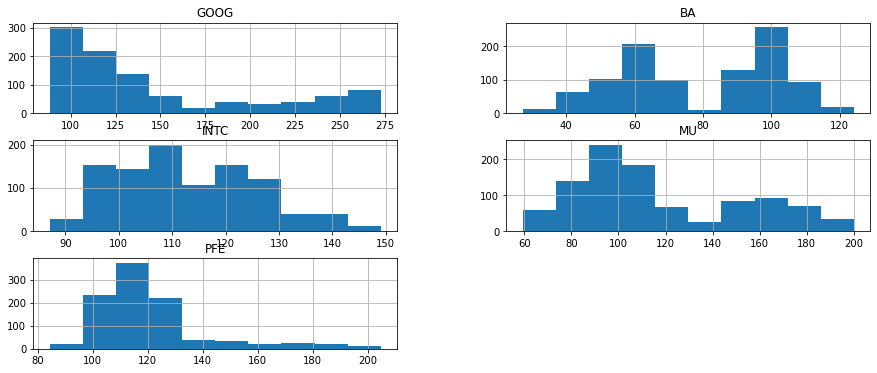

In [11]:
(portfolio / portfolio.iloc[0] * 100).hist(figsize = (15, 6));

In [12]:
returns = (portfolio / portfolio.shift(1)) - 1  # 0+/-
returns.tail()

,GOOG,BA,INTC,MU,PFE
Date,,,,,
2022-02-02,0.073674,-0.003936,0.011440,0.037569,0.014886
2022-02-03,-0.036383,-0.005445,-0.024843,-0.030056,-0.008912
2022-02-04,0.002562,0.000291,0.001983,-0.009760,-0.007119
2022-02-07,-0.028514,0.026496,0.003541,-0.003696,0.003962
2022-02-08,0.001979,0.006370,0.013076,0.040188,-0.028378


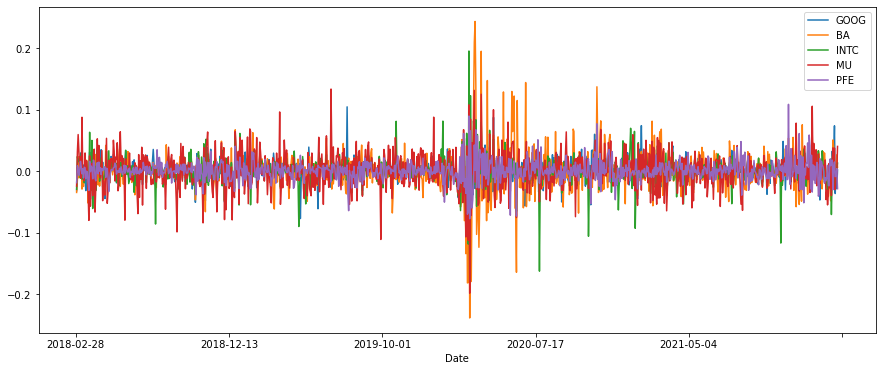

In [13]:
returns.plot(figsize = (15, 6));

In [14]:
annual_returns = returns.mean() * portfolio.shape[0] # mean in period
annual_returns

GOOG    1.096634
BA      0.048804
INTC    0.371507
MU      0.999268
PFE     0.689377
dtype: float64

In [15]:
cov_matrix_a = returns.cov() * portfolio.shape[0]
cov_matrix_a

,GOOG,BA,INTC,MU,PFE
GOOG,0.342117,0.251202,0.236913,0.291113,0.103668
BA,0.251202,1.071584,0.322359,0.429670,0.151818
INTC,0.236913,0.322359,0.555990,0.441806,0.125925
MU,0.291113,0.429670,0.441806,0.899487,0.117067
PFE,0.103668,0.151818,0.125925,0.117067,0.269733


In [16]:
cov_matrix_LOG = np.log(portfolio / portfolio.shift(1)).cov() * portfolio.shape[0]
cov_matrix_LOG

,GOOG,BA,INTC,MU,PFE
GOOG,0.342120,0.259351,0.239003,0.295226,0.104280
BA,0.259351,1.076033,0.336220,0.443954,0.156642
INTC,0.239003,0.336220,0.565806,0.449477,0.126172
MU,0.295226,0.443954,0.449477,0.907599,0.120066
PFE,0.104280,0.156642,0.126172,0.120066,0.268696


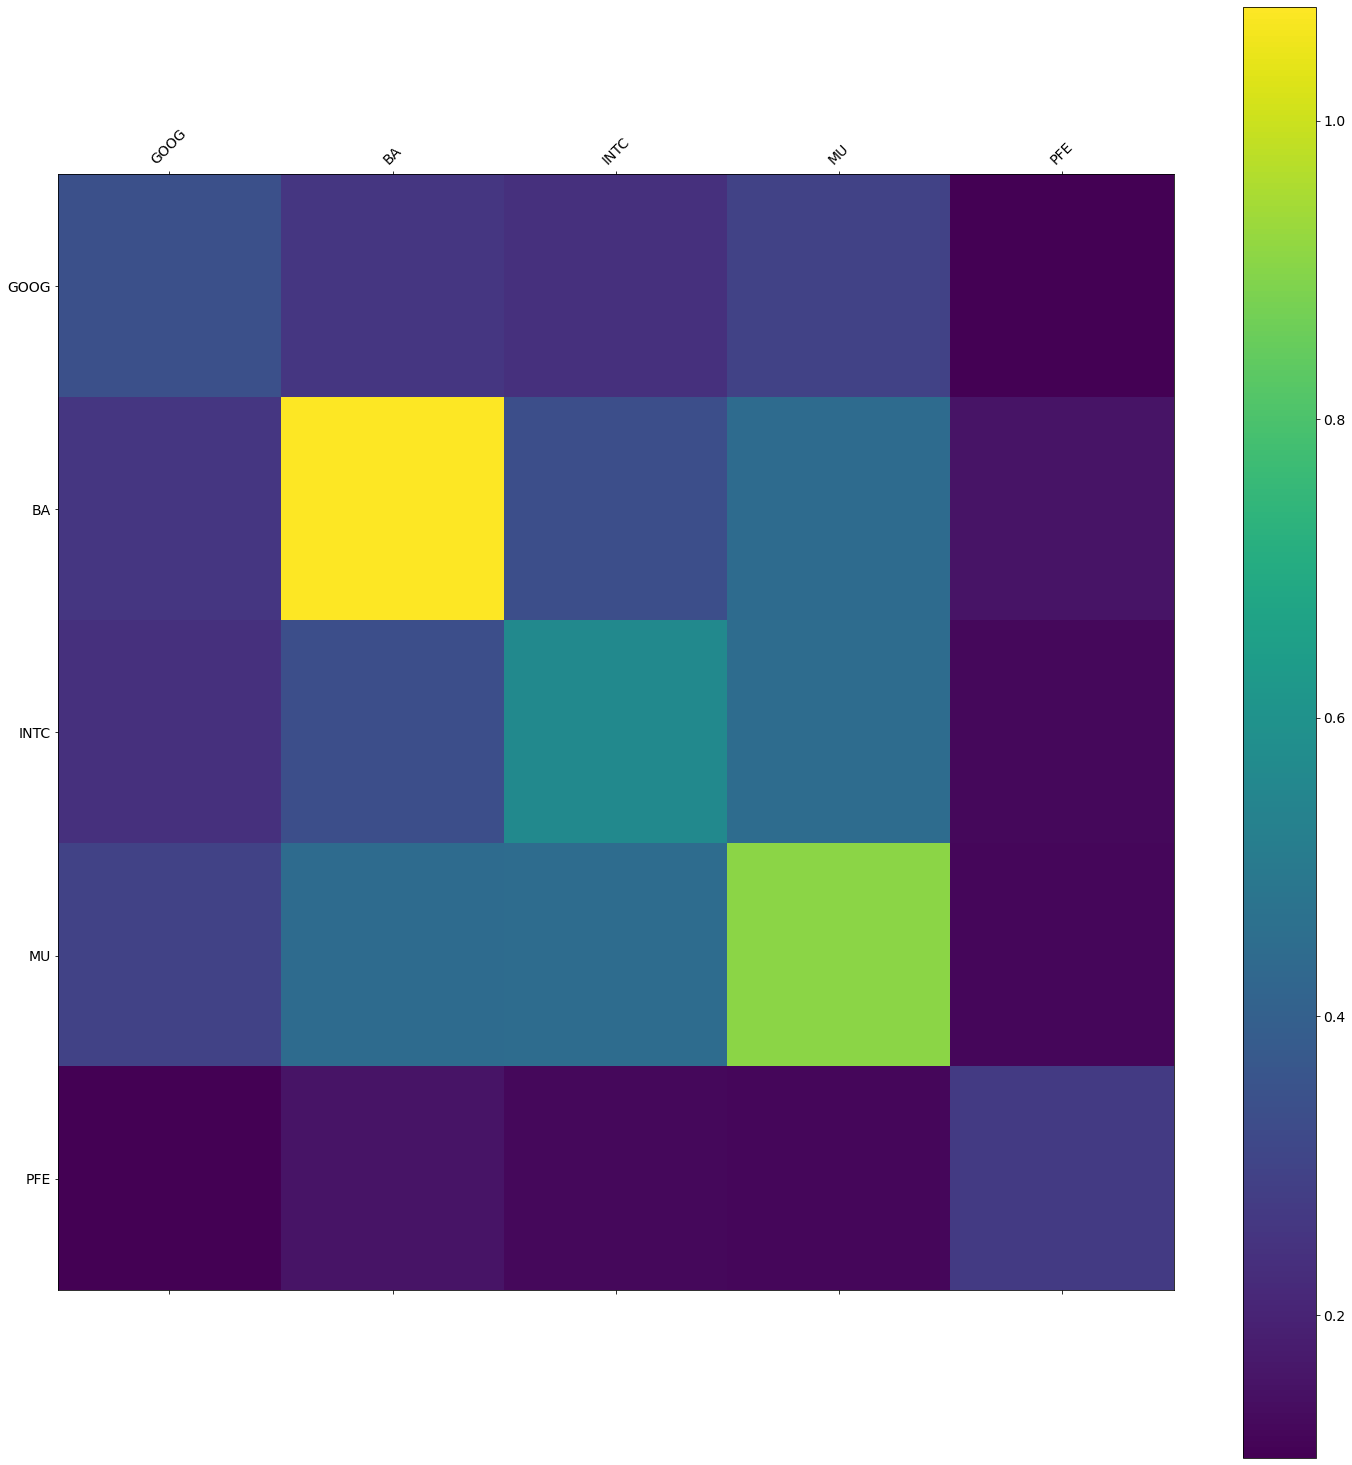

In [17]:
plt.figure(figsize=(25, 26))
plt.matshow(cov_matrix_LOG, fignum=1) #annot=True
plt.xticks(range(cov_matrix_LOG.shape[1]), cov_matrix_LOG.columns, fontsize=14, rotation=45)
plt.yticks(range(cov_matrix_LOG.shape[1]), cov_matrix_LOG.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.show()

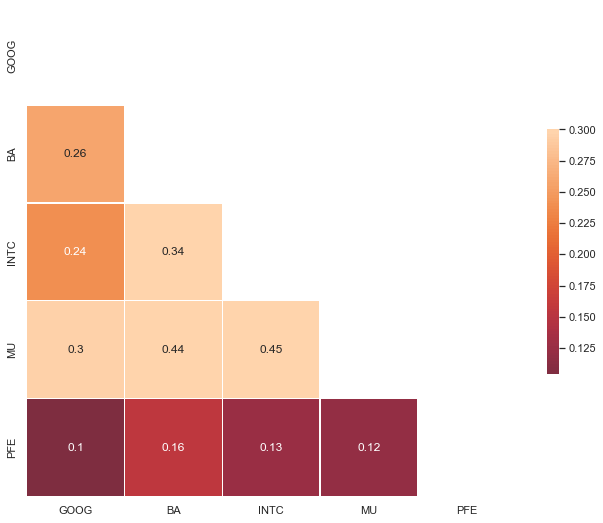

In [18]:
sns.set(style="whitegrid")
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(cov_matrix_LOG, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 20, sep=20, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(cov_matrix_LOG, mask=mask,  vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True,);

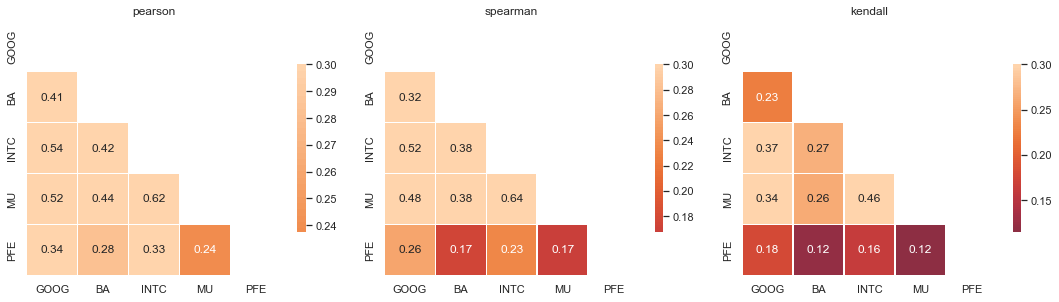

In [19]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,5))
sns.set(style="whitegrid")
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(cov_matrix_a, dtype=np.bool))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 20, sep=20, as_cmap=True)

for corr_type, ax in zip(('pearson', "spearman", 'kendall'),(ax1, ax2, ax3)):

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 20, sep=20, as_cmap=True)
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(returns.corr(method=corr_type), mask=mask,  vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, ax=ax)
    ax.set_title(corr_type)

plt.tight_layout()
plt.show();

In [20]:
## For Dimensionality Reduction
correlations = np.abs([np.corrcoef(portfolio["GOOG"],portfolio[col_name])[0,1] for col_name in tickers[1:]])
print (list(zip(tickers[1:],correlations)))

[('BA', 0.5292659094426732), ('INTC', 0.4252500645388979), ('MU', 0.8496430411190035), ('PFE', 0.773250521556244)]


In [21]:
correlations[correlations < .8]

array([0.52926591, 0.42525006, 0.77325052])

In [22]:
returns.isna().count()

GOOG    995
BA      995
INTC    995
MU      995
PFE     995
dtype: int64

In [23]:
returns.dropna(inplace = True) 
returns

,GOOG,BA,INTC,MU,PFE
Date,,,,,
2018-03-01,-0.031872,-0.034566,-0.029418,-0.024380,-0.018728
2018-03-02,0.008789,-0.014355,0.023829,0.031289,0.008981
2018-03-05,0.011132,0.023443,0.015721,0.059458,0.004729
2018-03-06,0.003786,-0.010857,0.019296,0.032866,-0.006644
2018-03-07,0.013314,-0.005388,0.012029,0.004280,0.001393
...,...,...,...,...,...
2022-02-02,0.073674,-0.003936,0.011440,0.037569,0.014886
2022-02-03,-0.036383,-0.005445,-0.024843,-0.030056,-0.008912
2022-02-04,0.002562,0.000291,0.001983,-0.009760,-0.007119


In [24]:
sem = pd.DataFrame(columns = ('pearson', "spearman", 'kendall'))
for corr_type in sem.columns:
    print (corr_type)
    sem[corr_type] = [returns['GOOG'].corr(other=returns["BA"], method=corr_type)] #.sem()
sem

pearson
spearman
kendall


,pearson,spearman,kendall
0,0.41488,0.324956,0.226345


In [25]:
[returns['GOOG'].corr(other=returns["BA"])]

[0.41487986274380706]

In [26]:
returns['GOOG'].sem() 

0.0005881428197025099

In [27]:
returns['GOOG'].mean() 

0.0011021443399262137

<AxesSubplot:>

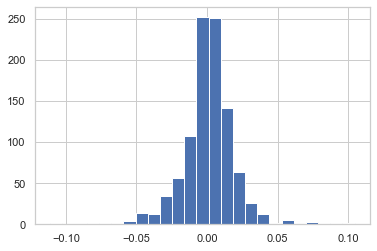

In [28]:
returns['GOOG'].hist(bins=25)